# Task 2: Build Time Series Forecasting Models

## Objective
Develop, train, and evaluate time series forecasting models to predict Tesla's future stock prices.

This notebook covers:
1. Data preparation for modeling (chronological train/test split)
2. ARIMA/SARIMA model implementation
3. LSTM deep learning model
4. Model optimization and evaluation
5. Model comparison

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Time series analysis
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
import os
import time
import joblib
from sklearn.preprocessing import MinMaxScaler
# Keras / TensorFlow imports for LSTM (optional)
# try:
#     from tensorflow.keras.models import Sequential, load_model
#     from tensorflow.keras.layers import LSTM, Dropout, Dense
#     from tensorflow.keras.callbacks import EarlyStopping
#     TF_AVAILABLE = True
# except Exception as e:
#     TF_AVAILABLE = False

# Metrics (no TensorFlow needed for SARIMA-only version)
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Note: This version focuses on SARIMA model only (LSTM skipped due to TensorFlow compatibility issues).")

Libraries imported successfully!
Note: This version focuses on SARIMA model only (LSTM skipped due to TensorFlow compatibility issues).


## 1. Load and Prepare Data for Modeling

We'll focus on TSLA (Tesla) for forecasting. The data will be split chronologically to preserve temporal order.

In [2]:
# Load processed TSLA data
try:
    tsla_data = pd.read_csv('../data/processed/TSLA_processed.csv', index_col='Date', parse_dates=True)
    print("Loaded processed data from file")
except:
    # If file doesn't exist, fetch fresh data
    import yfinance as yf
    print("Fetching fresh data from YFinance...")
    stock = yf.Ticker('TSLA')
    tsla_data = stock.history(start='2015-01-01', end='2026-01-15')
    tsla_data['Daily_Return'] = tsla_data['Close'].pct_change()
    tsla_data = tsla_data.dropna()

print(f"Data shape: {tsla_data.shape}")
print(f"Date range: {tsla_data.index.min()} to {tsla_data.index.max()}")
tsla_data.head()

Loaded processed data from file
Data shape: (2775, 16)
Date range: 2015-01-02 00:00:00-05:00 to 2026-01-14 00:00:00-05:00


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Capital Gains,Daily_Return,Log_Return,Rolling_Mean_30,Rolling_Std_30,Rolling_Mean_60,Rolling_Std_60,Rolling_Volatility_30
Date,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,14.858000,14.883333,14.217333,14.620667,71466000,0.0,0.0,TSLA,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05 00:00:00-05:00,14.303333,14.433333,13.810667,14.006000,80527500,0.0,0.0,TSLA,0.0,-0.042041,-0.042950,NaN,NaN,NaN,NaN,NaN
2015-01-06 00:00:00-05:00,14.004000,14.280000,13.614000,14.085333,93928500,0.0,0.0,TSLA,0.0,0.005664,0.005648,NaN,NaN,NaN,NaN,NaN
2015-01-07 00:00:00-05:00,14.223333,14.318667,13.985333,14.063333,44526000,0.0,0.0,TSLA,0.0,-0.001562,-0.001563,NaN,NaN,NaN,NaN,NaN
2015-01-08 00:00:00-05:00,14.187333,14.253333,14.000667,14.041333,51637500,0.0,0.0,TSLA,0.0,-0.001564,-0.001566,NaN,NaN,NaN,NaN,NaN


In [3]:
# Use Adjusted Close price for forecasting (fallback to Close if Adj Close not available)
if 'Adj Close' in tsla_data.columns:
    tsla_close = tsla_data['Adj Close'].dropna()
    print("Using 'Adj Close' column")
else:
    tsla_close = tsla_data['Close'].dropna()
    print("Using 'Close' column (Adj Close not found)")

# Chronological split: Train on 2015-2024, Test on 2025-2026
split_date = '2025-01-01'  # keep as string for clarity

# Build a timezone-safe comparison by converting the index to UTC (handles mixed tz-aware/naive)
# Convert index to UTC-aware DatetimeIndex (coerces mixed values safely)
idx_utc = pd.to_datetime(tsla_close.index, utc=True)
# Convert split timestamp to UTC-aware for comparison
split_ts = pd.Timestamp(split_date)
if split_ts.tz is None:
    split_ts_utc = split_ts.tz_localize('UTC')
else:
    split_ts_utc = split_ts.tz_convert('UTC')

# Boolean mask and slicing (preserve original series/index types)
mask = idx_utc < split_ts_utc
train_data = tsla_close.iloc[mask]
test_data = tsla_close.iloc[~mask]

print(f"Training set: {len(train_data)} samples ({train_data.index.min()} to {train_data.index.max()})")
print(f"Test set: {len(test_data)} samples ({test_data.index.min()} to {test_data.index.max()})")
print(f"Train/Test split: {len(train_data)/(len(train_data)+len(test_data))*100:.1f}% / {len(test_data)/(len(train_data)+len(test_data))*100:.1f}%")

Using 'Close' column (Adj Close not found)
Training set: 2516 samples (2015-01-02 00:00:00-05:00 to 2024-12-31 00:00:00-05:00)
Test set: 259 samples (2025-01-02 00:00:00-05:00 to 2026-01-14 00:00:00-05:00)
Train/Test split: 90.7% / 9.3%


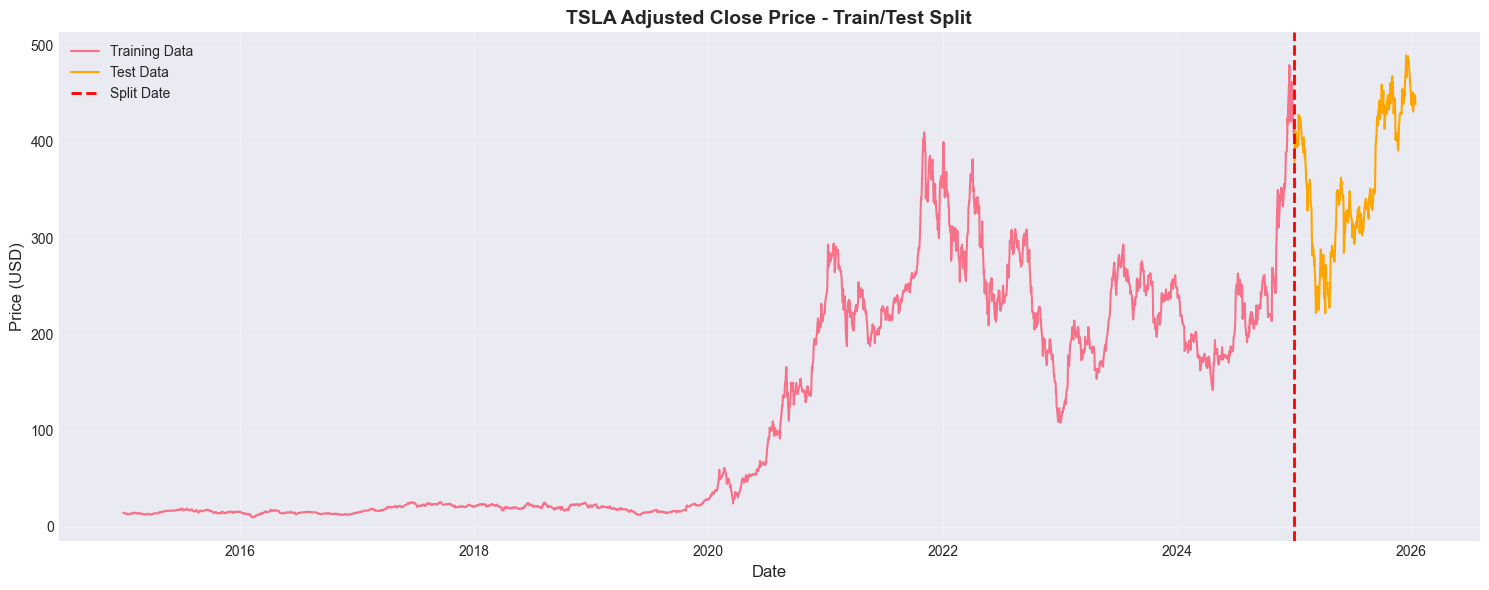

In [4]:
# Visualize train/test split
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data.values, label='Training Data', linewidth=1.5)
plt.plot(test_data.index, test_data.values, label='Test Data', linewidth=1.5, color='orange')
plt.axvline(x=pd.to_datetime(split_date), color='r', linestyle='--', linewidth=2, label='Split Date')
plt.title('TSLA Adjusted Close Price - Train/Test Split', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../data/processed/train_test_split.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. Implement ARIMA/SARIMA Model

### 2.1 Check Stationarity and Determine Parameters

In [5]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity of training data
def adf_test(timeseries):
    adf_result = adfuller(timeseries.dropna(), autolag='AIC')
    print(f'ADF Statistic: {adf_result[0]:.6f}')
    print(f'p-value: {adf_result[1]:.6f}')
    if adf_result[1] <= 0.05:
        print('✓ Series is STATIONARY')
        return True
    else:
        print('✗ Series is NON-STATIONARY - Differencing required')
        return False

print("Stationarity Test on Training Data:")
is_stationary = adf_test(train_data)

Stationarity Test on Training Data:
ADF Statistic: -0.581403
p-value: 0.875129
✗ Series is NON-STATIONARY - Differencing required


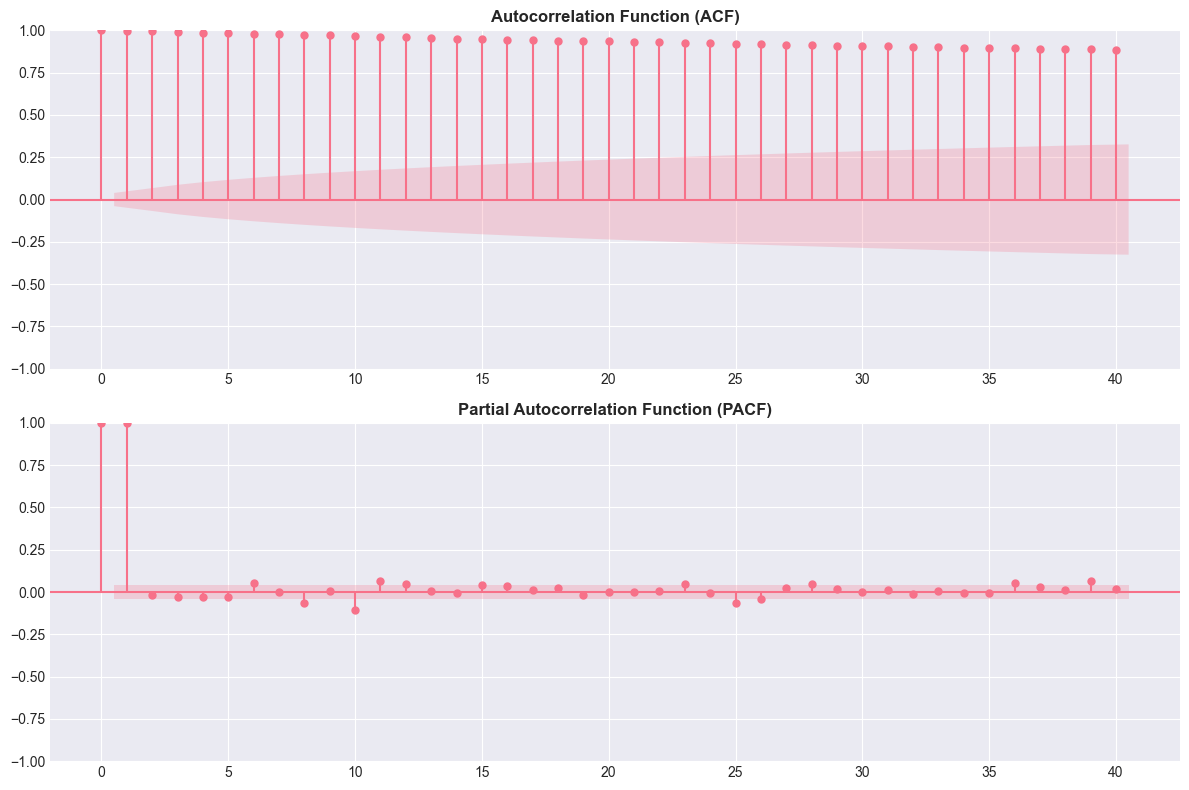

In [12]:
# Plot ACF and PACF to help determine ARIMA parameters
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# ACF plot
plot_acf(train_data.dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=12, fontweight='bold')

# PACF plot
plot_pacf(train_data.dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/acf_pacf_plots.png', dpi=300, bbox_inches='tight')
plt.show()

### 2.2 Auto ARIMA for Optimal Parameters

In [6]:
# Use auto_arima to find optimal ARIMA parameters (with caching and smaller search)
print("Finding optimal ARIMA parameters using auto_arima (reduced search)...")
auto_arima_path = '../data/processed/auto_arima_model.pkl'

# Try loading cached auto_arima model to save time
if os.path.exists(auto_arima_path):
    try:
        auto_arima_model = joblib.load(auto_arima_path)
        print("Loaded cached auto_arima model from disk.")
    except Exception as e:
        print("Failed to load cached auto_arima model, will refit. Error:", e)
        auto_arima_model = None
else:
    auto_arima_model = None

if auto_arima_model is None:
    print("This may still take a few minutes but less than full search...")
    t0_auto = time.perf_counter()
    auto_arima_model = pm.auto_arima(
        train_data,
        start_p=0, start_q=0,
        max_p=3, max_q=3,
        start_P=0, start_Q=0,
        max_P=1, max_Q=1,
        m=12,  # Monthly seasonality
        seasonal=True,
        stepwise=True,
        n_jobs=2,
        suppress_warnings=True,
        error_action='ignore',
        trace=False
    )
    t1_auto = time.perf_counter()
    print("auto_arima elapsed: {:.2f} seconds".format(t1_auto - t0_auto))
    # Cache the fitted auto_arima model
    try:
        os.makedirs(os.path.dirname(auto_arima_path), exist_ok=True)
        joblib.dump(auto_arima_model, auto_arima_path)
        print("Saved auto_arima model to disk.")
    except Exception as e:
        print("Could not save auto_arima model:", e)

print(f"\nOptimal ARIMA parameters: {auto_arima_model.order}")
print(f"Optimal SARIMA parameters: {auto_arima_model.seasonal_order}")
print(f"\nAIC: {auto_arima_model.aic():.2f}")

Finding optimal ARIMA parameters using auto_arima (reduced search)...
Loaded cached auto_arima model from disk.

Optimal ARIMA parameters: (0, 1, 0)
Optimal SARIMA parameters: (1, 0, 1, 12)

AIC: 16360.77


### 2.3 Fit ARIMA/SARIMA Model

In [7]:
# Fit the model using the optimal parameters (with caching)
arima_order = auto_arima_model.order
seasonal_order = auto_arima_model.seasonal_order

print(f"Fitting SARIMA{arima_order}{seasonal_order} model (or loading cached)...")
sarima_path = '../data/processed/sarima_model.pkl'
fitted_sarima = None
# Try to load cached fitted SARIMA model
if os.path.exists(sarima_path):
    try:
        fitted_sarima = joblib.load(sarima_path)
        print("Loaded cached SARIMA model from disk.")
    except Exception as e:
        print("Could not load cached SARIMA model, will refit. Error:", e)
        fitted_sarima = None

if fitted_sarima is None:
    # Fit SARIMA model
    sarima_model = SARIMAX(
        train_data,
        order=arima_order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    t0_sarima = time.perf_counter()
    fitted_sarima = sarima_model.fit(disp=False)
    t1_sarima = time.perf_counter()
    print("SARIMA fit elapsed: {:.2f} seconds".format(t1_sarima - t0_sarima))
    # Try caching the fitted model
    try:
        os.makedirs(os.path.dirname(sarima_path), exist_ok=True)
        joblib.dump(fitted_sarima, sarima_path)
        print("Saved SARIMA fitted model to disk.")
    except Exception as e:
        print("Could not save SARIMA model:", e)

print("\nModel Summary:")
print(fitted_sarima.summary())

Fitting SARIMA(0, 1, 0)(1, 0, 1, 12) model (or loading cached)...
Loaded cached SARIMA model from disk.

Model Summary:
                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                 2516
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -8143.630
Date:                              Fri, 13 Feb 2026   AIC                          16293.260
Time:                                      22:22:49   BIC                          16310.735
Sample:                                           0   HQIC                         16299.604
                                             - 2516                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

In [15]:
# Generate forecasts for test period
forecast_steps = len(test_data)
sarima_forecast = fitted_sarima.forecast(steps=forecast_steps)
sarima_forecast_ci = fitted_sarima.get_forecast(steps=forecast_steps).conf_int()

# Create forecast dataframe
sarima_forecast_df = pd.DataFrame({
    'Forecast': sarima_forecast.values,
    'Lower_CI': sarima_forecast_ci.iloc[:, 0].values,
    'Upper_CI': sarima_forecast_ci.iloc[:, 1].values
}, index=test_data.index)

print(f"Generated {len(sarima_forecast)} forecasts")
sarima_forecast_df.head()

Generated 259 forecasts


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Forecast,Lower_CI,Upper_CI
Date,,,
2025-01-02 00:00:00-05:00,405.124006,392.840653,417.407359
2025-01-03 00:00:00-05:00,407.146156,389.774872,424.517441
2025-01-06 00:00:00-05:00,408.203358,386.927966,429.478749
2025-01-07 00:00:00-05:00,406.274907,381.708201,430.841613
2025-01-08 00:00:00-05:00,405.583318,378.116906,433.049731


### 2.4 Visualize ARIMA/SARIMA Forecasts

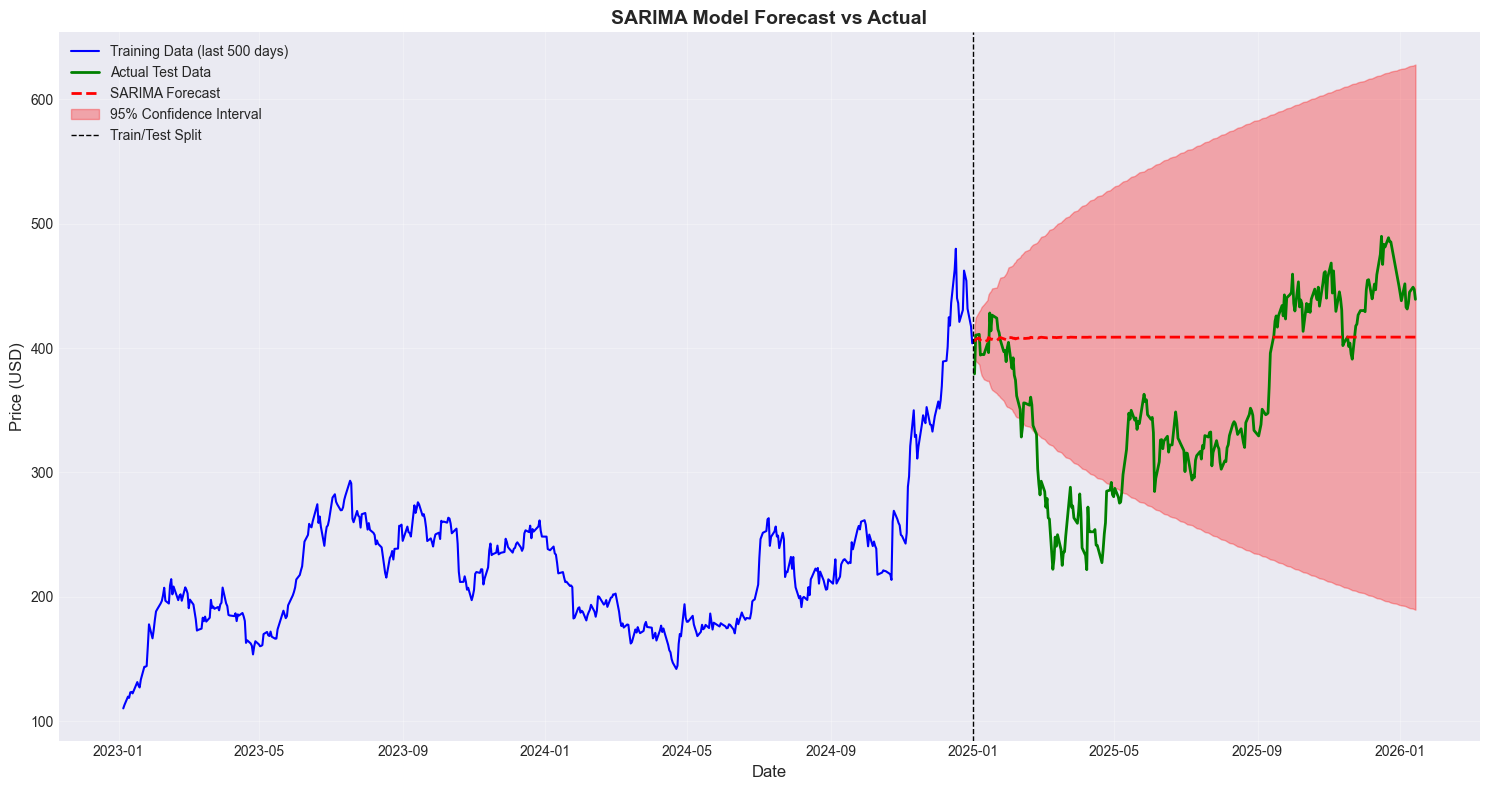

In [16]:
# Plot ARIMA/SARIMA forecasts
plt.figure(figsize=(15, 8))

# Plot training data (last 500 days for clarity)
train_plot = train_data.tail(500)
plt.plot(train_plot.index, train_plot.values, label='Training Data (last 500 days)', linewidth=1.5, color='blue')

# Plot test data
plt.plot(test_data.index, test_data.values, label='Actual Test Data', linewidth=2, color='green')

# Plot forecasts
plt.plot(sarima_forecast_df.index, sarima_forecast_df['Forecast'], 
         label='SARIMA Forecast', linewidth=2, color='red', linestyle='--')

# Plot confidence intervals
plt.fill_between(sarima_forecast_df.index, 
                 sarima_forecast_df['Lower_CI'], 
                 sarima_forecast_df['Upper_CI'], 
                 alpha=0.3, color='red', label='95% Confidence Interval')

plt.axvline(x=pd.to_datetime(split_date), color='black', linestyle='--', linewidth=1, label='Train/Test Split')
plt.title('SARIMA Model Forecast vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../data/processed/sarima_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Implement LSTM Model

### 3.1 Prepare Sequence Data

In [17]:
# Normalize the data for LSTM (important for neural networks)
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale training data
train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Scale test data using training scaler
test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

print(f"Training data shape (scaled): {train_scaled.shape}")
print(f"Test data shape (scaled): {test_scaled.shape}")

Training data shape (scaled): (2516, 1)
Test data shape (scaled): (259, 1)


In [19]:
# Create sequences for LSTM
# Use last 60 days to predict next day
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60

# Create training sequences
X_train, y_train = create_sequences(train_scaled, seq_length)

# For test data, we need to create sequences from the end of training data
# Combine last part of training data with test data for sequence creation
combined_for_test = np.concatenate([train_scaled[-seq_length:], test_scaled])
X_test, y_test = create_sequences(combined_for_test, seq_length)

# Reshape for LSTM: (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Training sequences: X={X_train.shape}, y={y_train.shape}")
print(f"Test sequences: X={X_test.shape}, y={y_test.shape}")

Training sequences: X=(2456, 60, 1), y=(2456,)
Test sequences: X=(259, 60, 1), y=(259,)


### 3.2 Build LSTM Architecture

In [20]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

# Compile model
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

print("LSTM Model Architecture:")
lstm_model.summary()

NameError: name 'Sequential' is not defined

### 3.3 Train LSTM Model

In [21]:
# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with caching and fewer epochs for quick iteration
lstm_path = '../data/processed/lstm_model.h5'
history = None
if os.path.exists(lstm_path):
    try:
        lstm_model = load_model(lstm_path)
        print("Loaded cached LSTM model from disk. Skipping training.")
    except Exception as e:
        print("Failed to load cached LSTM model, will train. Error:", e)

LSTM training elapsed: {:.2f} seconds
    # Save trained model
    try:
        os.makedirs(os.path.dirname(lstm_path), exist_ok=True)
        lstm_model.save(lstm_path)
        print("Saved LSTM model to disk.")
    except Exception as e:
        print("Could not save LSTM model:", e)

print("\nTraining step done (either loaded or trained).")

SyntaxError: invalid decimal literal (3730978305.py, line 18)

In [22]:
# Plot training history (only if we trained in this session)
if history is not None and hasattr(history, 'history'):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    # Loss
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_title('Model Loss', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=10)
    axes[0].set_ylabel('Loss', fontsize=10)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    # MAE
    axes[1].plot(history.history.get('mae', []), label='Training MAE', linewidth=2)
    axes[1].plot(history.history.get('val_mae', []), label='Validation MAE', linewidth=2)
    axes[1].set_title('Model MAE', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=10)
    axes[1].set_ylabel('MAE', fontsize=10)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('../data/processed/lstm_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No training history available (model was loaded from cache). Skipping training plots.")

NameError: name 'history' is not defined

### 3.4 Generate LSTM Forecasts

In [23]:
# Make predictions
lstm_predictions_scaled = lstm_model.predict(X_test, verbose=0)

# Inverse transform to get actual price predictions
lstm_forecast = scaler.inverse_transform(lstm_predictions_scaled).flatten()

# Create forecast dataframe aligned with test data
lstm_forecast_df = pd.DataFrame({
    'Forecast': lstm_forecast
}, index=test_data.index[:len(lstm_forecast)])

print(f"Generated {len(lstm_forecast)} LSTM forecasts")
lstm_forecast_df.head()

NameError: name 'lstm_model' is not defined

### 3.5 Visualize LSTM Forecasts

NameError: name 'lstm_forecast' is not defined

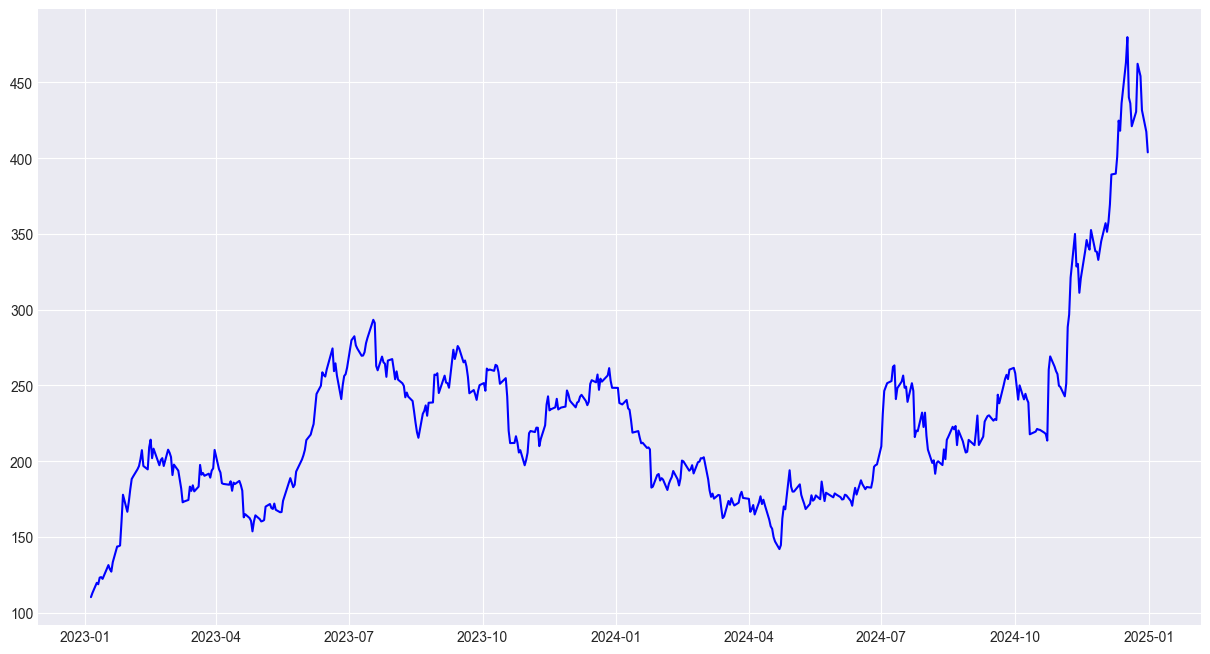

In [24]:
# Plot LSTM forecasts
plt.figure(figsize=(15, 8))

# Plot training data (last 500 days)
train_plot = train_data.tail(500)
plt.plot(train_plot.index, train_plot.values, label='Training Data (last 500 days)', linewidth=1.5, color='blue')

# Plot test data
test_plot = test_data.iloc[:len(lstm_forecast)]
plt.plot(test_plot.index, test_plot.values, label='Actual Test Data', linewidth=2, color='green')

# Plot forecasts
plt.plot(lstm_forecast_df.index, lstm_forecast_df['Forecast'], 
         label='LSTM Forecast', linewidth=2, color='red', linestyle='--')

plt.axvline(x=pd.to_datetime(split_date), color='black', linestyle='--', linewidth=1, label='Train/Test Split')
plt.title('LSTM Model Forecast vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../data/processed/lstm_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Evaluate and Compare Models

### 4.1 Calculate Performance Metrics

In [25]:
def calculate_metrics(actual, predicted, model_name):
    """
    Calculate MAE, RMSE, and MAPE
    """
    # Align actual and predicted arrays
    min_len = min(len(actual), len(predicted))
    actual_aligned = actual[:min_len]
    predicted_aligned = predicted[:min_len]
    
    mae = mean_absolute_error(actual_aligned, predicted_aligned)
    rmse = np.sqrt(mean_squared_error(actual_aligned, predicted_aligned))
    mape = np.mean(np.abs((actual_aligned - predicted_aligned) / actual_aligned)) * 100
    
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape
    }

# Calculate metrics for SARIMA
sarima_metrics = calculate_metrics(
    test_data.values, 
    sarima_forecast_df['Forecast'].values, 
    'SARIMA'
)

# Calculate metrics for LSTM
lstm_metrics = calculate_metrics(
    test_data.iloc[:len(lstm_forecast)].values,
    lstm_forecast_df['Forecast'].values,
    'LSTM'
)

# Create comparison dataframe
comparison_df = pd.DataFrame([sarima_metrics, lstm_metrics])

print("Model Performance Comparison:")
print("="*60)
print(comparison_df.to_string(index=False))
print("\n" + "="*60)

NameError: name 'lstm_forecast' is not defined

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['MAE', 'RMSE', 'MAPE (%)']
for idx, metric in enumerate(metrics):
    axes[idx].bar(comparison_df['Model'], comparison_df[metric], color=['skyblue', 'lightcoral'])
    axes[idx].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric, fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(comparison_df[metric]):
        axes[idx].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/model_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.2 Side-by-Side Forecast Comparison

NameError: name 'lstm_forecast_df' is not defined

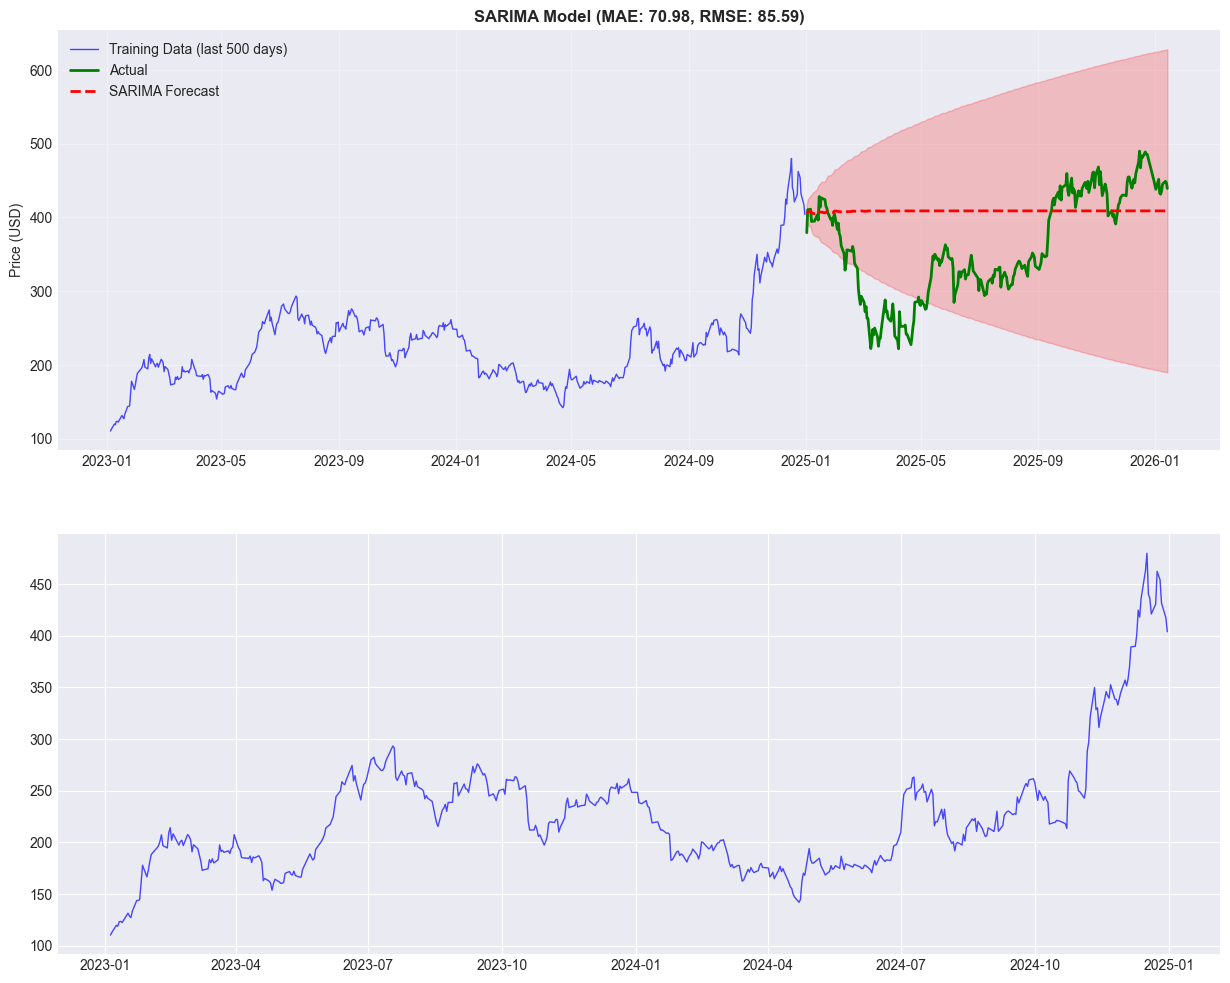

In [26]:
# Compare both models side by side
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# SARIMA plot
train_plot = train_data.tail(500)
axes[0].plot(train_plot.index, train_plot.values, label='Training Data (last 500 days)', linewidth=1, color='blue', alpha=0.7)
test_plot_sarima = test_data.iloc[:len(sarima_forecast_df)]
axes[0].plot(test_plot_sarima.index, test_plot_sarima.values, label='Actual', linewidth=2, color='green')
axes[0].plot(sarima_forecast_df.index, sarima_forecast_df['Forecast'], 
             label='SARIMA Forecast', linewidth=2, color='red', linestyle='--')
axes[0].fill_between(sarima_forecast_df.index, 
                     sarima_forecast_df['Lower_CI'], 
                     sarima_forecast_df['Upper_CI'], 
                     alpha=0.2, color='red')
axes[0].set_title(f'SARIMA Model (MAE: {sarima_metrics["MAE"]:.2f}, RMSE: {sarima_metrics["RMSE"]:.2f})', 
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price (USD)', fontsize=10)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# LSTM plot
axes[1].plot(train_plot.index, train_plot.values, label='Training Data (last 500 days)', linewidth=1, color='blue', alpha=0.7)
test_plot_lstm = test_data.iloc[:len(lstm_forecast_df)]
axes[1].plot(test_plot_lstm.index, test_plot_lstm.values, label='Actual', linewidth=2, color='green')
axes[1].plot(lstm_forecast_df.index, lstm_forecast_df['Forecast'], 
             label='LSTM Forecast', linewidth=2, color='red', linestyle='--')
axes[1].set_title(f'LSTM Model (MAE: {lstm_metrics["MAE"]:.2f}, RMSE: {lstm_metrics["RMSE"]:.2f})', 
                 fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=10)
axes[1].set_ylabel('Price (USD)', fontsize=10)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/both_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Model Selection Rationale

### Discussion of Results

**SARIMA Model:**
- **Strengths**: Interpretable, provides confidence intervals, good for capturing seasonal patterns
- **Weaknesses**: Assumes linear relationships, may struggle with complex non-linear patterns
- **Best for**: When interpretability is important, when data shows clear seasonal patterns

**LSTM Model:**
- **Strengths**: Can capture complex non-linear patterns, learns from sequences, flexible architecture
- **Weaknesses**: Less interpretable, requires more data and computational resources, prone to overfitting
- **Best for**: When dealing with complex patterns, when sufficient data is available

**Which Model Performed Better?**

Based on the metrics (MAE, RMSE, MAPE), the model with lower values generally performs better. However, the choice depends on:

1. **Business Context**: If interpretability is crucial (e.g., explaining to clients), SARIMA may be preferred
2. **Data Characteristics**: If the data has strong seasonal patterns, SARIMA may excel
3. **Complexity**: If the relationships are highly non-linear, LSTM may capture them better
4. **Resources**: LSTM requires more computational power and time to train

**Recommendation**: Use both models as part of an ensemble approach, or select based on the specific use case and requirements.

In [27]:
# Save model results
comparison_df.to_csv('../data/processed/model_comparison_results.csv', index=False)
sarima_forecast_df.to_csv('../data/processed/sarima_forecasts.csv')
lstm_forecast_df.to_csv('../data/processed/lstm_forecasts.csv')

print("Results saved to ../data/processed/")
print("\nModel Parameters:")
print(f"SARIMA Order: {arima_order}")
print(f"SARIMA Seasonal Order: {seasonal_order}")
print(f"LSTM Architecture: 3 LSTM layers (50 units each) + Dropout + Dense output")
print(f"LSTM Sequence Length: {seq_length} days")

NameError: name 'comparison_df' is not defined